## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
import os

## Preparing Data (Train and Test Sets)

In [2]:
IMG_SIZE = (100, 100)  # Size of images to be passed into the model
IMG_HEIGHT, IMG_WIDTH = 100, 100
# ---- For reproducibility ----- #
SEED = 123
BATCH_SIZE = 32

In [3]:
train_path = r"C:\Users\Deju\Downloads\archive\fruits-360_dataset\fruits-360\Training"  # (path hidden)
test_path = r"C:\Users\Deju\Downloads\archive\fruits-360_dataset\fruits-360\Test"

# ----- Create a train dataset object (tf.data.Dataset)----- #
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_path,
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
# ----- Create a test dataset object (tf.data.Dataset)----- #
test_set = tf.keras.utils.image_dataset_from_directory(
  shuffle=False, 
  directory=test_path, 
  label_mode="categorical",
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 67688 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.


## Model Creation and Training

In [4]:
# ----- Function to create sequential model type ----- #
def create_sequential_cnn(input_shape):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.InputLayer(input_shape=input_shape),
        
        # Convolutional blocks
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        # Global Average Pooling layer
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # Dense blocks
        tf.keras.layers.Dense(256, activation="relu", kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.2),
        
        # Output layer
        tf.keras.layers.Dense(131, activation="softmax")
    ])
    
    return model

In [5]:
cnn = create_sequential_cnn((IMG_HEIGHT, IMG_WIDTH, 3))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 256)      0

In [6]:
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  # Categorical cross-entropy loss function
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), # Stop after 5 epochs if val loss doesn't improve
    tf.keras.callbacks.ModelCheckpoint('./models/best_seq_cnn.h5', monitor='val_accuracy', save_best_only=True)  # Saves best model
]

epochs = 10  # Number of iterations (epochs) 

In [7]:
# ----- Initiaite model training ----- #
cnn_history = cnn.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
2116/2116 [==============================] - 80s 36ms/step - loss: 1.9405 - accuracy: 0.6414 - val_loss: 0.5546 - val_accuracy: 0.9205
Epoch 2/10
2116/2116 [==============================] - 79s 38ms/step - loss: 0.5044 - accuracy: 0.9184 - val_loss: 0.4014 - val_accuracy: 0.9509
Epoch 3/10
2116/2116 [==============================] - 84s 40ms/step - loss: 0.3790 - accuracy: 0.9479 - val_loss: 0.3784 - val_accuracy: 0.9545
Epoch 4/10
2116/2116 [==============================] - 90s 43ms/step - loss: 0.3259 - accuracy: 0.9602 - val_loss: 0.3033 - val_accuracy: 0.9733
Epoch 5/10
2116/2116 [==============================] - 91s 43ms/step - loss: 0.3044 - accuracy: 0.9655 - val_loss: 0.2915 - val_accuracy: 0.9701
Epoch 6/10
2116/2116 [==============================] - 91s 43ms/step - loss: 0.2734 - accuracy: 0.9715 - val_loss: 0.3221 - val_accuracy: 0.9696
Epoch 7/10
2116/2116 [==============================] - 89s 42ms/step - loss: 0.2763 - accuracy: 0.9737 - val_loss: 0.2436 -

## Model Evaluation

In [8]:
# ----- Function to plot training curves (loss and accuracy) ----- #
def plot_training_curves(model_history, model_name):

    history = model_history.history

    plt.figure(figsize=(15, 5))  # Size of the complete figure

    plt.subplot(1, 2, 1)  # Select first subplot
    plt.plot(history['loss'], label='Training loss') 
    plt.plot(history['val_loss'], label='Validation loss')
    plt.legend()  # Show the names for the color of lines in plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)  # Select second subplot
    plt.plot(history['accuracy'], label='Training accuracy')
    plt.plot(history['val_accuracy'], label='Validation accuracy')
    plt.legend()  # Show the names for the color of lines in plot
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
 
    plt.suptitle(f'{model_name} Training performance')  # Centered title for the figure
    plt.show()

# ----- Function for prediction using the model ----- #
def predict(dataset, model):
    pred_vals = np.argmax(model.predict(dataset), axis=-1)  # Values for predicted class/category by the model
    true_vals = np.concatenate([label for img, label in dataset], axis=0)
    true_vals = np.argmax(true_vals, axis=-1)  # Values for the actual class (category)
    # ----- Returns the predicted values and the true values ----- #
    return pred_vals, true_vals

# ----- Function to show the evaluation of the model ----- #
def show_performance_evaluation(dataset, model):  

    pred_vals, true_vals = predict(dataset, model)  # predict() function's return

    class_names = [folder_name for folder_name in os.listdir(train_path)]
    print("\n\nClassification Report:\n")
    print(classification_report(true_vals, pred_vals, labels=[i for i in range(0, 131)], target_names=class_names, zero_division=1))

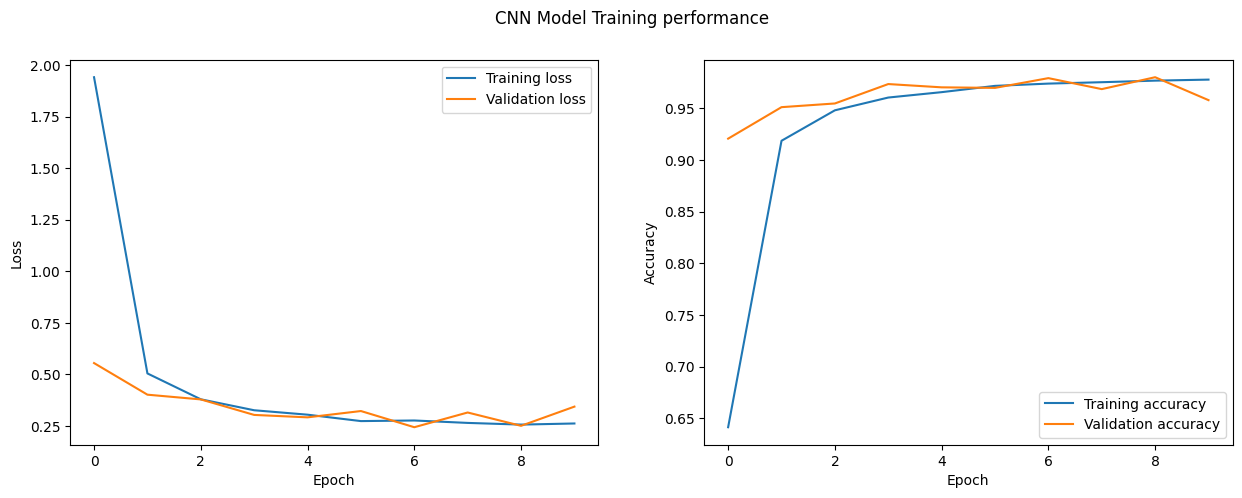

In [9]:
# ----- Show training (loss and accuracy) curves during the model training process ----- #
plot_training_curves(cnn_history, 'CNN Model')

In [10]:
final_model = tf.keras.models.load_model('./models/best_seq_cnn.h5')  #Load the model from the saved directory
show_performance_evaluation(dataset=test_set, model=final_model)

709/709 [==============================] - 11s 16ms/step


Classification Report:

                     precision    recall  f1-score   support

     Apple Braeburn       0.86      1.00      0.93       164
 Apple Crimson Snow       0.96      1.00      0.98       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.83      1.00      0.91       161
 Apple Granny Smith       0.89      0.99      0.94       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       1.00      1.00      1.00       164
        Apple Red 3       1.00      0.99      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.99      0.99       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
 